In [85]:
from unstructured.partition.auto import partition
from unstructured.partition.pdf import partition_pdf
from google import genai
from google.genai import types
import numpy as np
import chromadb
from dotenv import load_dotenv, dotenv_values

### Data Extraction from PDF

In [86]:
file_path = 'examples/maxwell-ems-school-improvement-2023.pdf'

elements = partition_pdf(
    filename=file_path, 
    strategy='hi_res',
    infer_table_structure=True,
    extract_image_block_types=["Image"],
    extract_image_block_to_payload=True,
    chunking_strategy="by_title",
    max_characters=10000,
    combine_text_under_n_chars=2000,
    new_after_n_chars=6000
    )

In [87]:
set([str(type(el)) for el in elements])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [88]:
# Each element is a chunk represented by a CompositeElement, which is used to store multiple elements of different types (Text, Image, Table, etc.)
for el in elements:
    print(type(el))
    print(el.to_dict())
    

<class 'unstructured.documents.elements.CompositeElement'>
{'type': 'CompositeElement', 'element_id': '8f66703fe2f955c3a7969d57acfd120e', 'text': 'Southeast District Cre Together We Serve\n\nMAXWELL SCHOOL IMPROVEMENT PLAN\n\nMaxwell Eagles S.O.A.R.\n\nSEPTEMBER 1, 2023\n\nDR. HYDE, PRINCIPAL; MR. EL-SHAAKIR, ASSISTANT PRINCIPAL DoDEA Americas Southeast District\n\nSchool Improvement Plan Framework\n\nVision/Mission\n\nThis document is Maxwell’s School Improvement Plan (SIP). The Plan is a roadmap and means to achieve the school’s vision and the attendant goals that follow from it. The vision, which follows directly from the District Improvement Plan (DIP), focuses on students, staff, and parents, which are three primary school stakeholders. The vision addresses broad, important outcomes for each group; they are achieving students, thriving staff, and engaged parents. The Plan also has a mission statement that guides the development of the strategies and actions necessary to achieve th

In [89]:
import pprint

pp = pprint.PrettyPrinter(indent=4)

for el in elements:
    pp.pprint(el.metadata.orig_elements)
    print("*" * 100)

[   <unstructured.documents.elements.Image object at 0x7d01644e5cd0>,
****************************************************************************************************
[   <unstructured.documents.elements.Title object at 0x7d01459e3bc0>,
****************************************************************************************************
[   <unstructured.documents.elements.Title object at 0x7d015ffc7740>,
****************************************************************************************************
[   <unstructured.documents.elements.Title object at 0x7d01442a9910>,
****************************************************************************************************
[   <unstructured.documents.elements.Title object at 0x7d01241cb470>,
****************************************************************************************************
[   <unstructured.documents.elements.Title object at 0x7d015fb09b50>,
***************************************************************************

In [90]:
# Looking at the extracted tables

original_elements = []

for el in elements:
    original_elements += el.metadata.orig_elements
    
tables = [el for el in original_elements if 'Table' in str(type(el))]
tables_html = [el.metadata.text_as_html for el in original_elements if 'Table' in str(type(el))]

for i in range(len(tables)):
    f = open(f"/home/mylee2662/Documents/education_walkthrough_lead/tables/table_{i}.html", 'w')
    f.write(tables_html[i])
    f.close

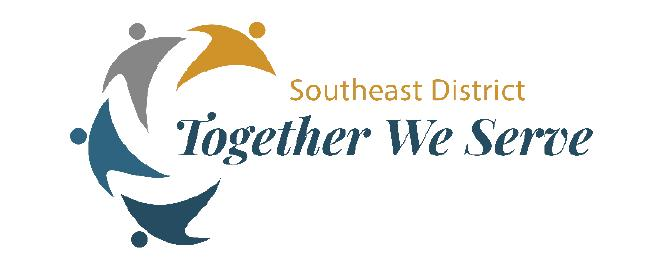

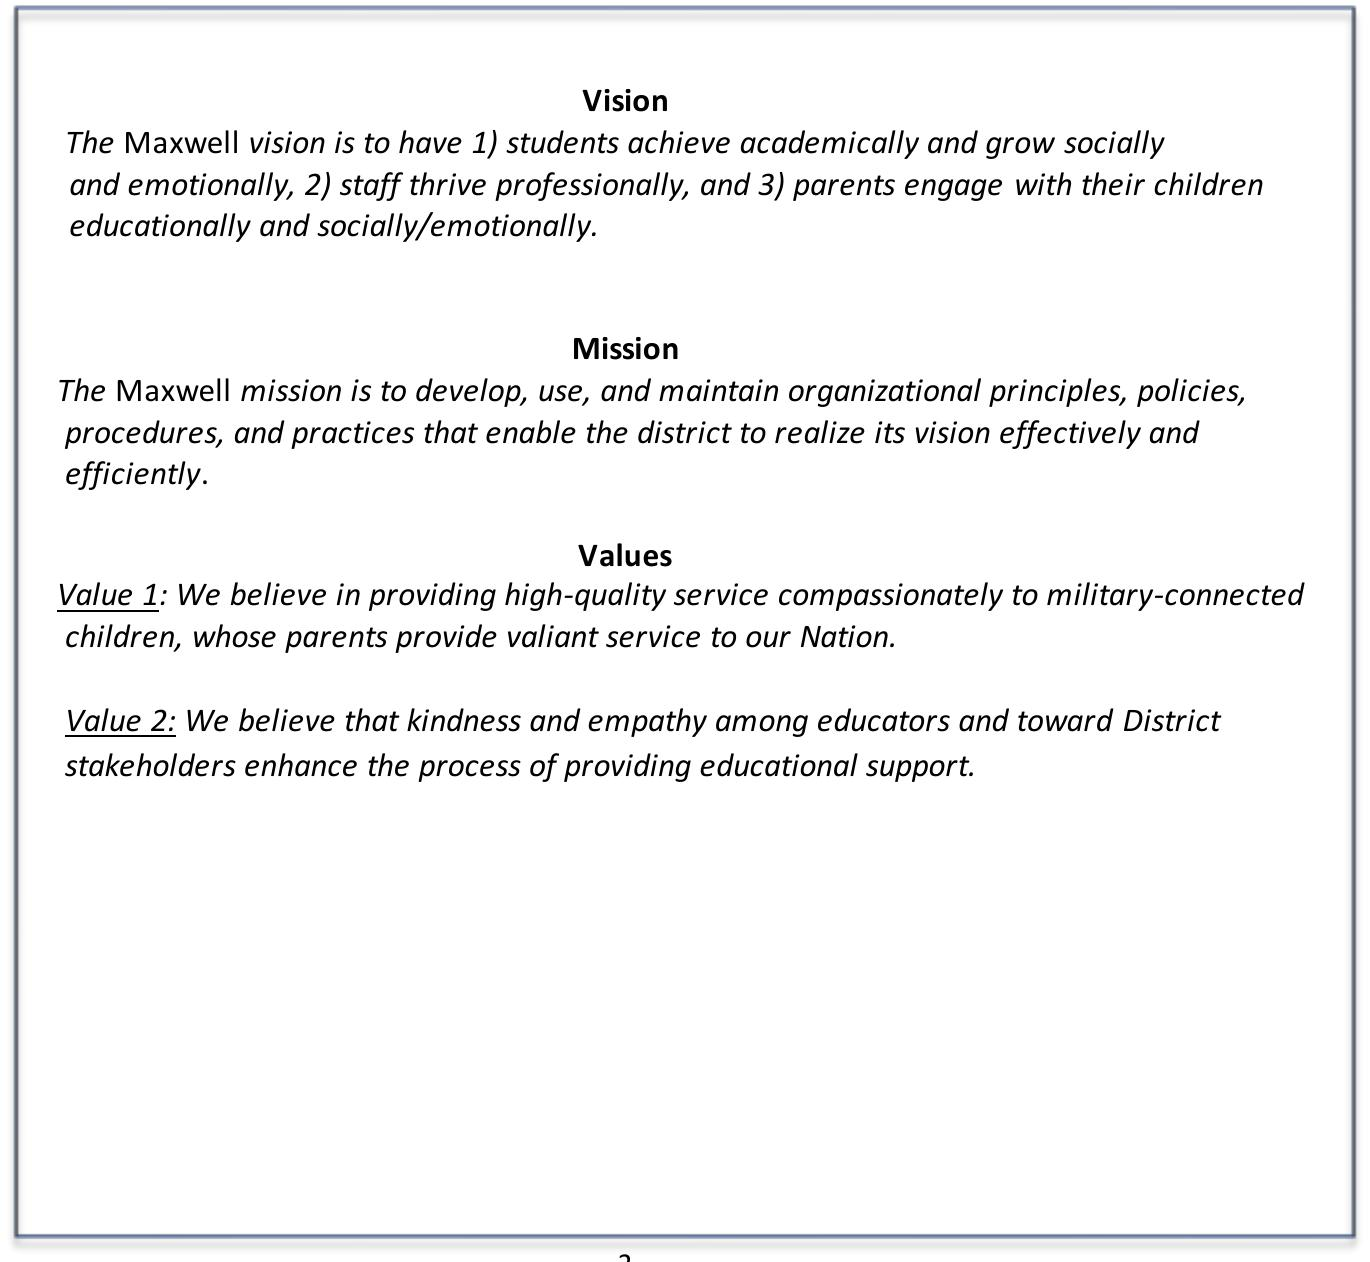

In [91]:
import base64
from IPython.display import Image, display

def display_image(image_base64):
    img_data = base64.b64decode(image_base64)
    display(Image(data=img_data))

    f = open(f"/home/mylee2662/Documents/education_walkthrough_lead/images/image_{i}.webp", 'wb')
    f.write(img_data)
    f.close

images = [el.metadata.image_base64 for el in original_elements if 'Image' in str(type(el))]

for i in range(len(images)):
    display_image(images[i])

In [92]:
texts = [el for el in elements if 'CompositeElement' in str(type(el))]

for text in texts:
    print(text)
    print('*' * 100)

Southeast District Cre Together We Serve

MAXWELL SCHOOL IMPROVEMENT PLAN

Maxwell Eagles S.O.A.R.

SEPTEMBER 1, 2023

DR. HYDE, PRINCIPAL; MR. EL-SHAAKIR, ASSISTANT PRINCIPAL DoDEA Americas Southeast District

School Improvement Plan Framework

Vision/Mission

This document is Maxwell’s School Improvement Plan (SIP). The Plan is a roadmap and means to achieve the school’s vision and the attendant goals that follow from it. The vision, which follows directly from the District Improvement Plan (DIP), focuses on students, staff, and parents, which are three primary school stakeholders. The vision addresses broad, important outcomes for each group; they are achieving students, thriving staff, and engaged parents. The Plan also has a mission statement that guides the development of the strategies and actions necessary to achieve the vision. Finally, two value statements reflect the school’s purpose and beliefs, which are to deliver high- quality service with empathy and kindness.

Vision T

In [93]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

load_dotenv()

summarization_model = ChatOpenAI(model="gpt-4o")

text_table_summarization_prompt = ChatPromptTemplate.from_template(
    """
    You are an assistant tasked with summarizing tables and text.
    Give a concise summary of the table or text.

    Respond only with the summary, no additional comment.
    Do not start your message by saying "Here is a summary" or anything like that.
    Just give the summary as it is.

    Table or text chunk: {element}
    """
)

text_table_summarize_chain = {"element": lambda x: x} | text_table_summarization_prompt | summarization_model | StrOutputParser()

img_summarization_prompt_text = """Describe the image in detail. For context,
                  the image is part of a school district's improvement plan document.
                  Be specific about graphs and text content.
                  Respond only with the description of the image, no additional comment.
                  """

img_summarization_messages = [
    (
        "user",
        [
            {
                "type": "text",
                "text": img_summarization_prompt_text
            },
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"}
            }
        ]
    )
]

img_summarization_prompt = ChatPromptTemplate.from_messages(img_summarization_messages)

img_summarize_chain = img_summarization_prompt | summarization_model | StrOutputParser()

In [94]:
text_summaries = text_table_summarize_chain.batch(texts)
pp.pprint(text_summaries)

[   "Maxwell School's Improvement Plan, led by Principal Dr. Hyde and "
    "Assistant Principal Mr. El-Shaakir, outlines the school's vision, "
    'mission, and values as part of the DoDEA Americas Southeast District. The '
    'vision focuses on achieving academic and social-emotional growth for '
    'students, professional thriving for staff, and engagement for parents. '
    'The mission involves developing and using effective organizational '
    'principles to realize this vision. The plan emphasizes delivering '
    'high-quality service compassionately to military-connected children and '
    'fostering kindness and empathy among educators and stakeholders.',
    'The SIP content outlines goals and strategies for students, staff, and '
    'parents aimed at improving academic performance and well-being. For '
    'students, the focus is on math and literacy achievement, and '
    'social/emotional health. Staff goals target pedagogical skills and '
    'social/emotional healt

In [95]:
table_summaries = text_table_summarize_chain.batch(tables)
pp.pprint(table_summaries)

[   'The table outlines goal areas for student, staff, and parent visions, '
    'focusing on academic growth, emotional well-being, thriving, and '
    'engagement. Specific goals include math and ELA achievement, '
    'social/emotional development, teacher pedagogy, and social/emotional '
    'support. Several indicators measure progress, such as the Writing Claim '
    'at 45% and Language Conventions at 76%. The table also lists forthcoming '
    'LWT and FCOT scores, parent and faculty survey questions, and supports '
    'like a writing framework and communication plans. Key percentages are '
    'FCOT 5d (95%), 5e (93%), and survey responses covering involvement and '
    'engagement.',
    'The student objectives focus on achieving high academic achievement in '
    'literacy and math. For literacy, the school aims to increase the average '
    'scaled score from 36 in SY 22/23 to 45 by SY 25/26, despite an unmet '
    'standard of 50 and no sustained improvement. For math, th

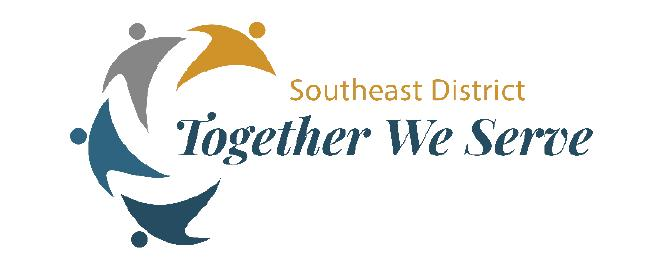

The image features a logo with abstract shapes resembling stylized human figures in different colors: gray, gold, and blue, forming a circle. Next to the logo, the text reads "Southeast District" in a gold font. Below that, in a larger, blue cursive font, it says "Together We Serve."


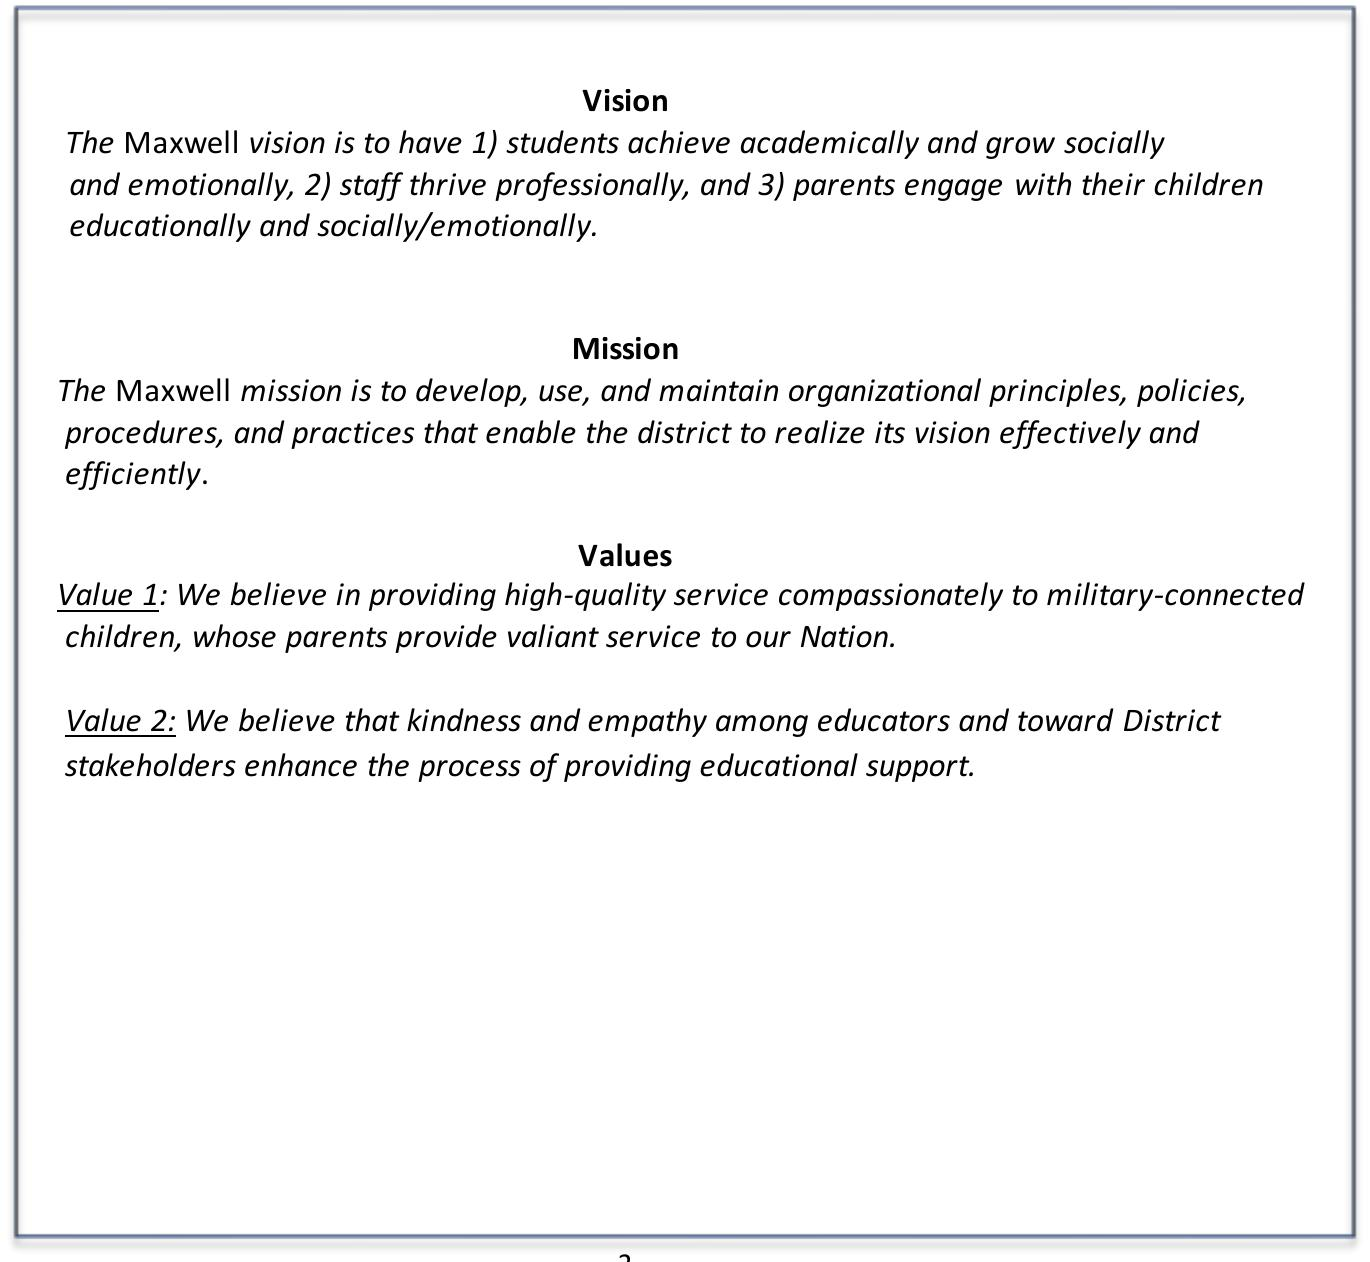

The image contains a section of a school district's improvement plan document. It is divided into three main parts: Vision, Mission, and Values.

**Vision:**
The Maxwell vision aims for:
1. Students to achieve academically and grow socially and emotionally.
2. Staff to thrive professionally.
3. Parents to engage with their children educationally and socially/emotionally.

**Mission:**
The Maxwell mission is to develop, use, and maintain organizational principles, policies, procedures, and practices that enable the district to realize its vision effectively and efficiently.

**Values:**
- **Value 1:** Emphasizes providing high-quality service compassionately to military-connected children, recognizing the valiant service of their parents to the nation.
- **Value 2:** Highlights the importance of kindness and empathy among educators and toward district stakeholders to enhance the provision of educational support.

The document has a professional tone and is formatted with clear headings 

In [96]:
image_summaries = img_summarize_chain.batch(images)
for i in range(len(images)):
    img_data = base64.b64decode(images[i])
    display(Image(data=img_data))
    print(image_summaries[i])

# pp.pprint(image_summaries)

### Embed Data

In [97]:
import uuid
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

vectorstore = Chroma(collection_name="summaries", embedding_function=OpenAIEmbeddings())

store = InMemoryStore()
id_key = "doc_id"

retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key
)

text_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [Document(page_content=text, metadata={id_key: text_ids[i]}) for i, text in enumerate(text_summaries)]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(text_ids, texts)))

table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [Document(page_content=table, metadata={id_key: table_ids[i]}) for i, table in enumerate(table_summaries)]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

image_ids = [str(uuid.uuid4()) for _ in images]
summary_images = [Document(page_content=img, metadata={id_key: image_ids[i]}) for i, img in enumerate(image_summaries)]
retriever.vectorstore.add_documents(summary_images)
retriever.docstore.mset(list(zip(image_ids, images)))

In [101]:
response  = retriever.invoke("What is the Maxwell vision?")
pp.pprint(response)

[   '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCATuBVoDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+oLu7isrdp522xr1NT1zfjh8eF7kZ9Ka3Bi/8Jvox6SSn6JS/wDCbaN/fm/791zXgzSNOu/DkUs8RaQu2Tu966D/AIR/SP8An3P/AH0av935k+8S/wDCbaN/fm/790f8Jto/9+b/AL91F/wj+kf8+5/76NH/AAj+k/8

In [ ]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage

def parse_docs(docs):
    retrieved_images, retrieved_texts = [], []

    for doc in docs:
        try:
            base64.b64decode(doc)
            retrieved_images.append(doc)
        except Exception as e:
            retrieved_texts.append(doc)

    return {
        "images": retrieved_images,
        "texts": retrieved_texts
    }

def build_prompt(kwargs):
    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    for retrieved_text in docs_by_type["texts"]:
        context_text += retrieved_text.text

    prompt_text = f"""
        Answer the question based only on the following context, which can include text, tables, and the below image.
        Context: {context_text}
        Question: {user_question}
    """

    prompt_content = [{
        "type": "text",
        "text": prompt_text
    }]

    if(len(docs_by_type["images"]) > 0):
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"}
                }
            )

    return ChatPromptTemplate(
        [
            HumanMessage(content=prompt_content)
        ]
    )

In [149]:
chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough()
} | RunnablePassthrough().assign(
    response = (
        RunnableLambda(build_prompt)
        | ChatOpenAI(model="gpt-4o")
        | StrOutputParser()
    )
)

chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatOpenAI(model="gpt-4o-mini")
    | StrOutputParser()
)

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCATuBVoDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+oLu7isrdp522xr1NT1zfjh8eF7kZ9Ka3Bi/8Jvox6SSn6JS/wDCbaN/fm/791zXgzSNOu/DkUs8RaQu2Tu966D/AIR/SP8An3P/AH0av935k+8S/wDCbaN/fm/790f8Jto/9+b/AL91F/wj+kf8+5/76NH/AAj+k/8APA
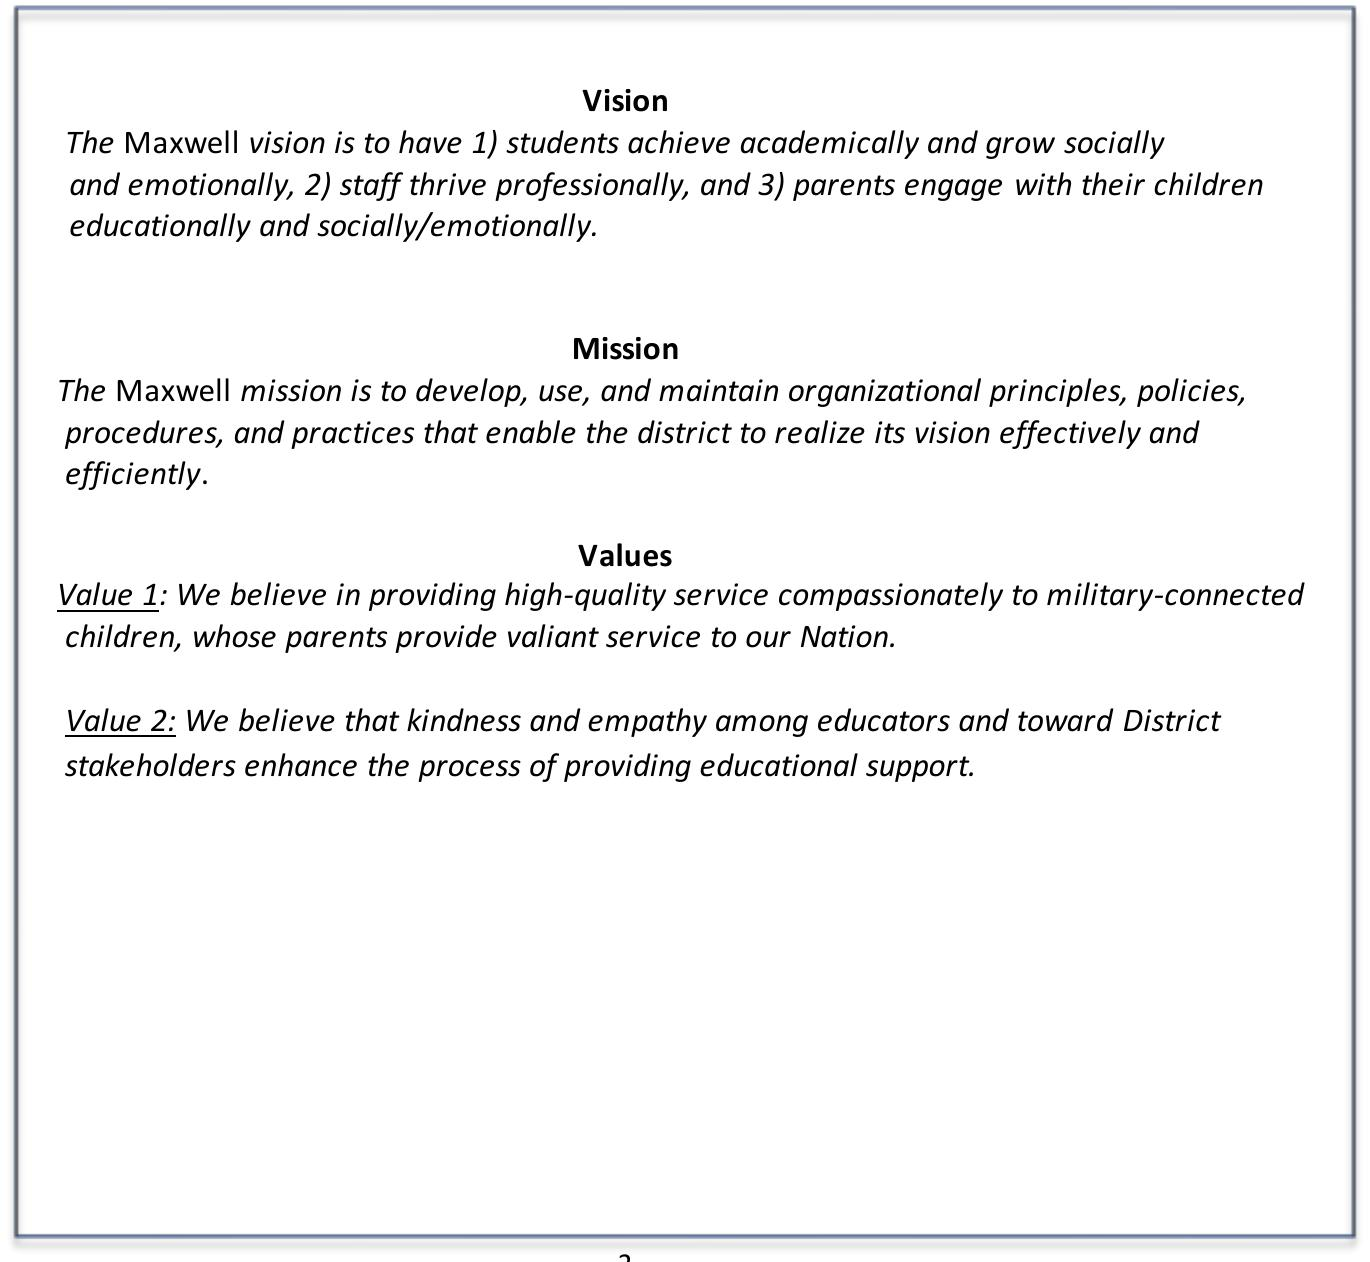

In [159]:
response = chain_with_sources.invoke("What is the Maxwell vision?")

print(response['response'])